In [10]:

%load_ext autoreload
%autoreload 2

In [18]:
import imaging as ic
#from skimage.io import imread,find_available_plugins
from tifffile import imread
import cv2
from glob import glob
import pylab as plt
import numpy as np


In [3]:
%matplotlib notebook
import time
tstart = time.time()
stack = ic.TiffStack(glob('/Users/joao/data/2photon/*.tif'))

print ((time.time() - tstart))


Opening stack files
0.551123857498


In [121]:
from os.path import join as pjoin
from tempfile import mkdtemp
import os
import numpy as np
from multiprocessing import Pool
from functools import partial
import time

def _tiff_to_mmap(filesandoffset, targetfile=None,shape = [None,None,None],dtype=np.uint16,order = 'F'):
    fd = np.memmap(targetfile,shape = shape,dtype = dtype,order = order,mode = 'r+')
    # Read tiff and dump to file. 
    fname,offset = filesandoffset
    data = imread(fname)
    N,w,h = data.shape
    fd[offset:offset+N,:,:] = data
    fd.flush()

def tiffsToMemmap(filenames=[], offsets=[], targetfile=None,
                  dtype=np.uint16, shape=None, order = 'F', 
                  multiprocessing=True,nworkers = 8):
    # create the file first
    if shape is None:
        raise ValueError,'Shape is empty'
    if targetfile is None:
        # Use a temp folder
        targetfolder = mkdtemp()
    elif os.path.isdir(targetfile):
        # Use foldername if no folder is specified
        targetfolder = targetfile
        targetfile = None
    else:
        targetfolder = os.dirname(targetfile)
        targetfile = os.basename(targetfile)
    if targetfile is None:
        # Create a filename from the shape and order
        targetfile = 'mmap_{0}_{1}_{2}.bin'.format('x'.join([str(s) for s in shape]),
                                                  str(dtype().dtype),order)
    targetfile = pjoin(targetfolder,targetfile)
    # Create memmap
    fd = np.memmap(targetfile,shape = shape,dtype = dtype,order = order,mode = 'w+')
    func = partial(_tiff_to_mmap, targetfile = targetfile,shape = shape,dtype = dtype,order = order)
    tstart = time.time()
    if multiprocessing:
        pool = Pool(nworkers)
        pool.map_async(func,zip(filenames,offsets))
        pool.close()
        pool.join()
    else:
        for f,o in zip(filenames,offsets):
            func((f,o))
    print('Done in {0} min'.format((time.time()-tstart)/60.))
    return np.memmap(targetfile,shape = shape,dtype = dtype,order = order)


In [122]:
data = tiffsToMemmap(filenames = stack.filenames,offsets = stack.framesOffset, shape=stack.shape)

Done in 0.0875581026077 min


<IPython.core.display.Javascript object>


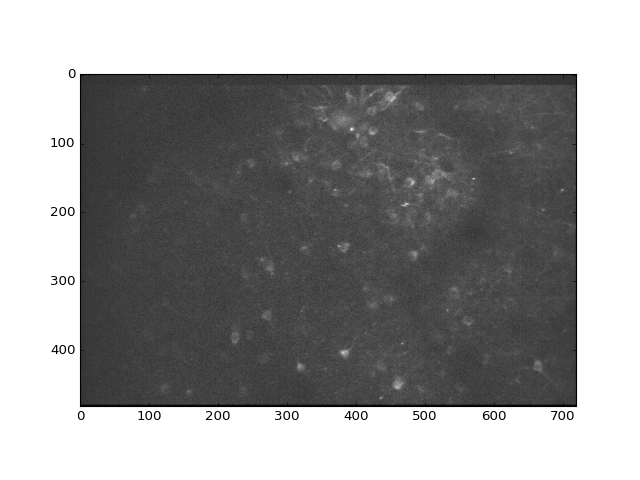

In [123]:
%matplotlib notebook
plt.imshow(np.mean(data,axis=0),cmap='gray')


In [49]:
import os
tstart = time.time()
tstart = time.time()
dat = stack[0:-1]
%matplotlib notebook
plt.imshow(dat.mean(axis=0)**2,cmap='hot',clim=[70,700])


<IPython.core.display.Javascript object>